# Proyecto Final de Data Science - Interconnect

## Introducción

En este proyecto final, continuamos nuestro trabajo con la empresa de telecomunicaciones **Interconnect**, que desea predecir la probabilidad de cancelación de sus clientes. El objetivo es desarrollar un modelo de aprendizaje automático capaz de identificar a los clientes con mayor riesgo de cancelar su contrato. Esto permitirá a la empresa ofrecer promociones y opciones de retención adecuadas, ayudando a reducir la tasa de cancelación y mantener una base de clientes más estable.

Después de realizar un análisis exploratorio de datos y plantear preguntas aclaratorias al equipo de liderazgo, contamos ahora con un conjunto claro de pasos a seguir. En este apartado, nos enfocaremos en el desarrollo del código de solución para cumplir con los objetivos del proyecto. 

### Objetivo

Desarrollar y evaluar un modelo de clasificación que prediga con precisión la probabilidad de cancelación de cada cliente, utilizando diferentes enfoques y métricas de evaluación adecuadas para los datos desbalanceados.

### Servicios de Interconnect

Interconnect ofrece diversos servicios de telecomunicaciones:
- **Telefonía fija** con posibilidad de múltiples líneas.
- **Internet** mediante conexión DSL o fibra óptica.
- Servicios adicionales como **seguridad en Internet** (protección antivirus y bloqueador de sitios maliciosos), **soporte técnico**, **almacenamiento en la nube**, **streaming de TV** y **directorio de películas**.

Además, los clientes pueden elegir entre diferentes tipos de contrato (mensual, 1 año o 2 años) y métodos de pago, con opción a recibir facturación electrónica.

### Descripción de los Datos

Los datos consisten en cuatro archivos que contienen la información relevante de los clientes:
1. `contract.csv` - Información sobre el contrato de cada cliente.
2. `personal.csv` - Datos personales del cliente.
3. `internet.csv` - Información sobre los servicios de Internet contratados.
4. `phone.csv` - Información sobre los servicios telefónicos.

Cada archivo contiene una columna llamada `customerID`, que representa un identificador único para cada cliente, permitiendo enlazar la información entre los diferentes archivos.

### Estructura del Código de Solución

A continuación, se presenta la estructura del código y los pasos que seguiremos para desarrollar la solución, desde la preparación inicial de datos hasta el entrenamiento y evaluación de diferentes modelos de clasificación.

### Tabla de Contenido

- [Inicialización](#inicialización)
- [Preprocesamiento de datos](#preprocesamiento-de-datos)
- [Análisis exploratorio de datos (EDA)](#análisis-exploratorio-de-datos-eda)
- [Entrenamiento y evaluación de modelos](#entrenamiento-y-evaluación-de-modelos)
  - [Preparar conjuntos de datos](#preparar-conjuntos-de-datos)
  - [Función para evaluar modelos](#función-para-evaluar-modelos)
  - [Modelos de regresión logística](#modelos-de-regresión-logística)
  - [Modelos de árbol de clasificación](#modelos-de-árbol-de-clasificación)
  - [Modelos de bosque aleatorio para clasificación](#modelos-de-bosque-aleatorio-para-clasificación)
  - [Modelos CatBoostClassifier](#Modelos-catboostclassifier)
- [Conclusiones](#Conclusiones)

Este esquema permitirá mantener una estructura organizada en el proyecto y ayudará a los revisores a evaluar cada sección de manera clara.



In [1]:
# Importamos las librerías necesarias
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

# Manejo de advertencias para evitar mensajes en exceso
import warnings
warnings.filterwarnings("ignore")

# Cargar los archivos CSV en DataFrames
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')


In [2]:
# Vista preliminar de cada DataFrame
print("Contract Data:")
display(contract_df.head())
print("\nPersonal Data:")
display(personal_df.head())
print("\nInternet Data:")
display(internet_df.head())
print("\nPhone Data:")
display(phone_df.head())

Contract Data:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Personal Data:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Internet Data:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Phone Data:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [3]:
# Información general de cada DataFrame
print("\nContract Data Info:")
contract_df.info()
print("\nPersonal Data Info:")
personal_df.info()
print("\nInternet Data Info:")
internet_df.info()
print("\nPhone Data Info:")
phone_df.info()


Contract Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Personal Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Pa

## Preprocesamiento de datos

En esta sección, realizaremos el preprocesamiento de los datos para preparar el conjunto de datos que utilizaremos en el análisis y el desarrollo del modelo de predicción. El objetivo del preprocesamiento es limpiar y estructurar los datos, de manera que estén listos para el entrenamiento del modelo de aprendizaje automático.

### Pasos

1. **Manejo de valores faltantes**: Identificaremos y trataremos los valores nulos en los archivos, asegurándonos de manejar los valores faltantes de acuerdo con las instrucciones del líder de equipo (por ejemplo, etiquetando ciertos servicios como "No aplica" cuando corresponda).
2. **Conversión de tipos de datos**: Transformaremos las columnas de fechas y variables categóricas para garantizar que se interpreten correctamente por los algoritmos de machine learning.
3. **Creación de la variable objetivo**: Basándonos en la columna `EndDate`, crearemos una variable que indique si un cliente ha cancelado su contrato.
4. **Unificación de datos**: Uniremos los datos de los diferentes archivos en un solo DataFrame, utilizando el `customerID` como identificador único para cada cliente.

Este proceso de preprocesamiento asegurará que los datos estén en el formato adecuado y optimizados para el análisis y el desarrollo del modelo.


In [4]:
# Rellenamos los valores faltantes en los archivos de Internet y Teléfono
# Asumimos que los valores faltantes indican que el cliente no tiene el servicio
internet_df.fillna("No aplica", inplace=True)
phone_df.fillna("No aplica", inplace=True)

# Verificamos si quedan valores nulos en cada DataFrame
print("Valores nulos en contract_df:")
print(contract_df.isnull().sum())
print("\nValores nulos en personal_df:")
print(personal_df.isnull().sum())
print("\nValores nulos en internet_df:")
print(internet_df.isnull().sum())
print("\nValores nulos en phone_df:")
print(phone_df.isnull().sum())


Valores nulos en contract_df:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Valores nulos en personal_df:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Valores nulos en internet_df:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Valores nulos en phone_df:
customerID       0
MultipleLines    0
dtype: int64


In [5]:
# Convertimos las columnas de fecha en el DataFrame 'contract_df' a tipo datetime
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], errors='coerce')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')

# Convertimos las columnas categóricas a tipo 'category' en todos los DataFrames
# En 'contract_df'
contract_df['Type'] = contract_df['Type'].astype('category')
contract_df['PaperlessBilling'] = contract_df['PaperlessBilling'].astype('category')
contract_df['PaymentMethod'] = contract_df['PaymentMethod'].astype('category')

# En 'personal_df'
personal_df['gender'] = personal_df['gender'].astype('category')
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].astype('category')
personal_df['Partner'] = personal_df['Partner'].astype('category')
personal_df['Dependents'] = personal_df['Dependents'].astype('category')

# En 'internet_df'
internet_df['InternetService'] = internet_df['InternetService'].astype('category')
internet_df['OnlineSecurity'] = internet_df['OnlineSecurity'].astype('category')
internet_df['OnlineBackup'] = internet_df['OnlineBackup'].astype('category')
internet_df['DeviceProtection'] = internet_df['DeviceProtection'].astype('category')
internet_df['TechSupport'] = internet_df['TechSupport'].astype('category')
internet_df['StreamingTV'] = internet_df['StreamingTV'].astype('category')
internet_df['StreamingMovies'] = internet_df['StreamingMovies'].astype('category')

# En 'phone_df'
phone_df['MultipleLines'] = phone_df['MultipleLines'].astype('category')

# Verificamos los cambios en los tipos de datos
print("Contract Data Types:\n", contract_df.dtypes)
print("\nPersonal Data Types:\n", personal_df.dtypes)
print("\nInternet Data Types:\n", internet_df.dtypes)
print("\nPhone Data Types:\n", phone_df.dtypes)


Contract Data Types:
 customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                      category
PaperlessBilling          category
PaymentMethod             category
MonthlyCharges             float64
TotalCharges                object
dtype: object

Personal Data Types:
 customerID         object
gender           category
SeniorCitizen    category
Partner          category
Dependents       category
dtype: object

Internet Data Types:
 customerID            object
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
dtype: object

Phone Data Types:
 customerID         object
MultipleLines    category
dtype: object


In [6]:
# Verificamos si hay valores no numéricos en 'TotalCharges'
# Reemplazamos los valores vacíos (si existen) por NaN para luego convertir la columna a float
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')

# Revisamos si quedan valores nulos después de la conversión
missing_total_charges = contract_df['TotalCharges'].isnull().sum()
print(f"Total de valores nulos en 'TotalCharges' después de la conversión: {missing_total_charges}")


Total de valores nulos en 'TotalCharges' después de la conversión: 11


In [7]:
# En este caso, reemplazaremos los nulos con la mediana de la columna para no afectar el análisis
if missing_total_charges > 0:
    median_total_charges = contract_df['TotalCharges'].median()
    contract_df['TotalCharges'].fillna(median_total_charges, inplace=True)
    print(f"Valores nulos en 'TotalCharges' rellenados con la mediana: {median_total_charges}")

# Confirmamos que 'TotalCharges' ahora es numérica y que no quedan valores nulos
print("\nTipos de datos en contract_df después de la conversión:")
print(contract_df.dtypes)
print("\nValores nulos en 'TotalCharges' después del reemplazo:")
print(contract_df['TotalCharges'].isnull().sum())

Valores nulos en 'TotalCharges' rellenados con la mediana: 1397.475

Tipos de datos en contract_df después de la conversión:
customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                      category
PaperlessBilling          category
PaymentMethod             category
MonthlyCharges             float64
TotalCharges               float64
dtype: object

Valores nulos en 'TotalCharges' después del reemplazo:
0


In [8]:
# Creamos la variable objetivo 'Churn'
# Si 'EndDate' tiene un valor, eso indica que el cliente canceló el contrato (Churn = 1)
# Si 'EndDate' es nulo, el cliente sigue activo (Churn = 0)
contract_df['Churn'] = contract_df['EndDate'].notnull().astype(int)

# Verificamos la distribución de la variable objetivo
print("Distribución de la variable objetivo 'Churn':")
print(contract_df['Churn'].value_counts())


Distribución de la variable objetivo 'Churn':
0    5174
1    1869
Name: Churn, dtype: int64


In [9]:
# Unificamos los DataFrames en uno solo usando 'customerID' como clave
# Empezamos uniendo 'contract_df' y 'personal_df'
data_df = pd.merge(contract_df, personal_df, on='customerID', how='left')

# Agregamos 'internet_df' a la unificación
data_df = pd.merge(data_df, internet_df, on='customerID', how='left')

# Agregamos 'phone_df' a la unificación
data_df = pd.merge(data_df, phone_df, on='customerID', how='left')

# Verificamos la estructura del DataFrame unificado
print("Dimensiones del DataFrame unificado:", data_df.shape)
print("Primeras filas del DataFrame unificado:")
display(data_df.head())
print("\nInformación del DataFrame unificado:")
data_df.info()


Dimensiones del DataFrame unificado: (7043, 21)
Primeras filas del DataFrame unificado:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No



Información del DataFrame unificado:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   category      
 11  Partner           7043 non-null   category      
 12  Dependents        7043 non-null   category      
 13  InternetService   5517 non-null   catego

## Resultados de la Unificación de Datos

La unificación de los datos ha sido completada con éxito, y ahora contamos con un DataFrame consolidado (`data_df`) que incluye toda la información relevante de los clientes. A continuación, se presentan algunos detalles importantes sobre este DataFrame:

- **Dimensiones**: El DataFrame unificado tiene 7043 filas y 21 columnas, lo cual confirma que se han conservado todos los registros de los DataFrames originales.
- **Columnas y tipos de datos**: Todas las columnas esperadas están presentes, y los tipos de datos han sido ajustados según lo necesario (por ejemplo, fechas en formato `datetime`, categorías en formato `category` y variables numéricas en `float64`).
- **Distribución de la variable objetivo**: Se ha creado la variable `Churn`, la cual indica si el cliente ha cancelado el contrato (`1`) o si permanece activo (`0`).

Este DataFrame consolidado está listo para el análisis exploratorio de datos (EDA), lo que nos permitirá explorar patrones y relaciones que pueden ser útiles para predecir la cancelación de clientes.


## Análisis Exploratorio de Datos (EDA)

En esta sección, realizaremos un análisis exploratorio de datos (EDA) para comprender mejor la estructura y las características del conjunto de datos unificado. El objetivo del EDA es identificar patrones, tendencias, y relaciones entre las variables que podrían ser útiles para el modelado de la cancelación de clientes.

### Pasos del EDA

1. **Distribución de la variable objetivo (`Churn`)**: Comenzaremos explorando la distribución de la variable objetivo para entender el balance de clases entre clientes activos y cancelados.
2. **Análisis de variables categóricas**: Examinaremos la distribución de las variables categóricas, como el tipo de contrato, método de pago, servicios contratados, entre otros, para identificar patrones relevantes en relación con la cancelación.
3. **Análisis de variables numéricas**: Analizaremos las variables numéricas (como `MonthlyCharges` y `TotalCharges`) y sus estadísticas descriptivas para ver su relación con la cancelación de clientes.
4. **Correlación entre variables**: Evaluaremos la correlación entre las variables numéricas y la variable objetivo, con el fin de identificar las relaciones más fuertes que podrían ser útiles para el modelo.

El EDA nos permitirá identificar características clave que podrían influir en la cancelación de clientes y nos ayudará a definir las mejores variables para nuestro modelo de predicción.


### Distribución de la variable objetivo (`Churn`)

En este primer paso del EDA, analizaremos la distribución de la variable objetivo `Churn` para comprender el balance de clases entre clientes activos (`0`) y clientes que han cancelado el contrato (`1`). Este análisis es fundamental, ya que un desbalance en la variable objetivo puede influir en las métricas de evaluación del modelo y en su desempeño.

Si el conjunto de datos está desbalanceado (es decir, si hay significativamente más clientes activos que cancelados o viceversa), es posible que necesitemos considerar técnicas de re-muestreo o métricas de evaluación que tengan en cuenta este desbalance.


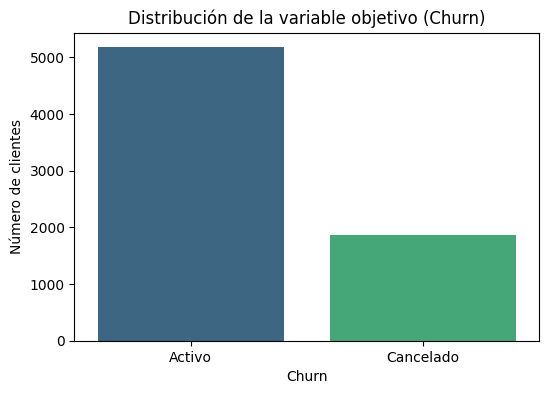

Conteo de cada clase en la variable objetivo 'Churn':
0    73.463013
1    26.536987
Name: Churn, dtype: float64


In [10]:
# Visualizamos la distribución de la variable objetivo 'Churn'
plt.figure(figsize=(6, 4))
sns.countplot(data=data_df, x='Churn', palette='viridis')
plt.title('Distribución de la variable objetivo (Churn)')
plt.xlabel('Churn')
plt.ylabel('Número de clientes')
plt.xticks([0, 1], ['Activo', 'Cancelado'])
plt.show()

# Mostramos el conteo de cada clase en 'Churn'
print("Conteo de cada clase en la variable objetivo 'Churn':")
print(data_df['Churn'].value_counts(normalize=True) * 100)


### Análisis de variables categóricas

En este paso, exploraremos la distribución de las variables categóricas en el conjunto de datos y su relación con la variable objetivo `Churn`. Este análisis nos permitirá identificar patrones y características que podrían estar asociados con una mayor o menor probabilidad de cancelación.

Algunas de las variables categóricas que analizaremos incluyen:
- **Type** (Tipo de contrato)
- **PaperlessBilling** (Facturación sin papel)
- **PaymentMethod** (Método de pago)
- **InternetService** (Tipo de servicio de Internet)
- **MultipleLines** (Líneas telefónicas múltiples)
- Entre otras variables de servicios adicionales como `OnlineSecurity`, `TechSupport`, etc.

Estas exploraciones iniciales nos ayudarán a identificar características relevantes para el modelo de predicción de cancelación.


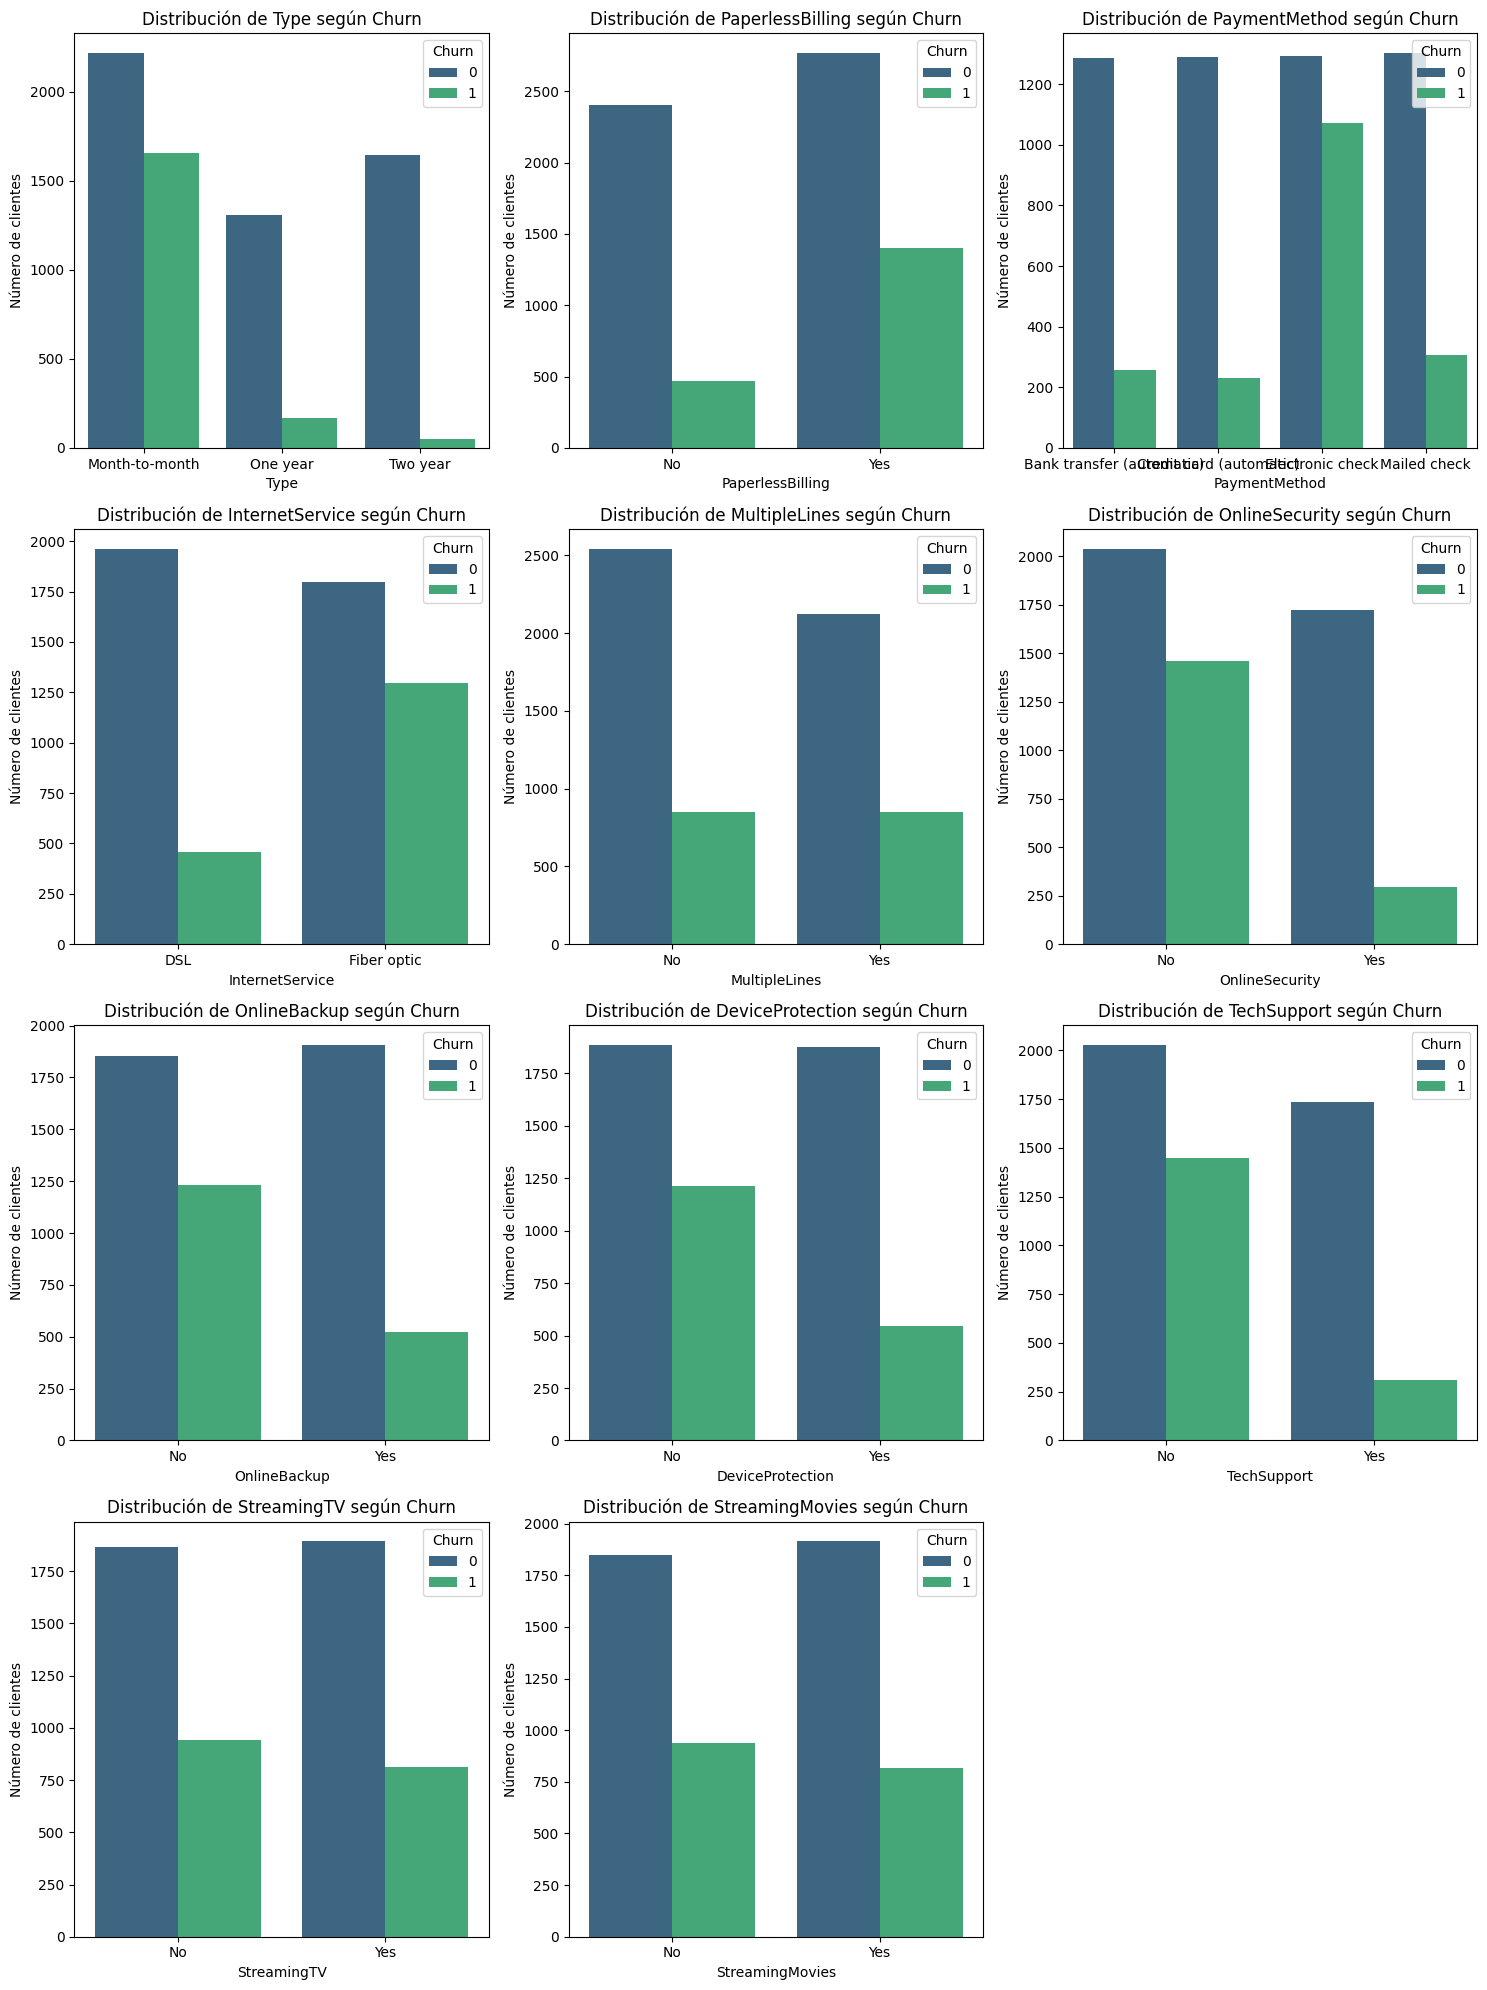

In [11]:
# Lista de variables categóricas a analizar
categorical_columns = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Configuración del tamaño de las gráficas
plt.figure(figsize=(15, 20))

# Gráficos de barras para cada variable categórica con respecto a 'Churn'
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=data_df, x=column, hue='Churn', palette='viridis')
    plt.title(f"Distribución de {column} según Churn")
    plt.xlabel(column)
    plt.ylabel("Número de clientes")
    plt.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()


### Análisis de variables numéricas

En este paso del EDA, analizaremos las variables numéricas del conjunto de datos y su relación con la variable objetivo `Churn`. Las variables numéricas incluyen:

- **MonthlyCharges**: Cargos mensuales que paga el cliente.
- **TotalCharges**: Cargos totales acumulados que ha pagado el cliente.

Este análisis nos permitirá observar cómo los cargos mensuales y totales pueden estar asociados con la probabilidad de cancelación. Utilizaremos estadísticas descriptivas y visualizaciones para comprender mejor la distribución de estas variables y su relación con `Churn`.


Estadísticas descriptivas de MonthlyCharges y TotalCharges:
       MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2281.916928
std         30.090047   2265.270398
min         18.250000     18.800000
25%         35.500000    402.225000
50%         70.350000   1397.475000
75%         89.850000   3786.600000
max        118.750000   8684.800000


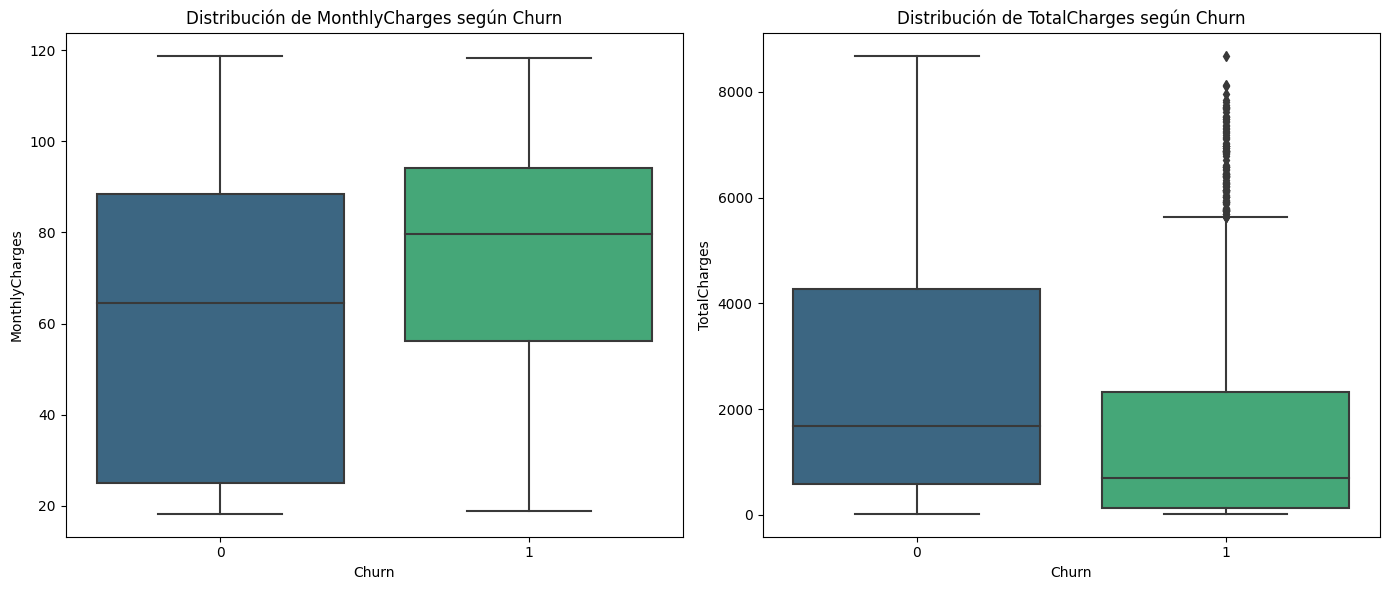

In [12]:
# Estadísticas descriptivas para las variables numéricas
print("Estadísticas descriptivas de MonthlyCharges y TotalCharges:")
print(data_df[['MonthlyCharges', 'TotalCharges']].describe())

# Visualización de la distribución de MonthlyCharges y TotalCharges según Churn
plt.figure(figsize=(14, 6))

# Distribución de MonthlyCharges
plt.subplot(1, 2, 1)
sns.boxplot(data=data_df, x='Churn', y='MonthlyCharges', palette='viridis')
plt.title("Distribución de MonthlyCharges según Churn")
plt.xlabel("Churn")
plt.ylabel("MonthlyCharges")

# Distribución de TotalCharges
plt.subplot(1, 2, 2)
sns.boxplot(data=data_df, x='Churn', y='TotalCharges', palette='viridis')
plt.title("Distribución de TotalCharges según Churn")
plt.xlabel("Churn")
plt.ylabel("TotalCharges")

plt.tight_layout()
plt.show()


### Correlación entre variables

En este paso, analizaremos la correlación entre las variables numéricas en el conjunto de datos y la variable objetivo `Churn`. El análisis de correlación nos permitirá identificar las relaciones más fuertes entre las variables, lo cual puede ser útil para seleccionar las características más relevantes para el modelo.

Nos enfocaremos en:
- **MonthlyCharges** y **TotalCharges**: Variables numéricas que ya hemos analizado y que pueden tener una relación con `Churn`.
- Visualización de un mapa de calor para observar las correlaciones de manera visual.

Este análisis nos ayudará a comprender qué variables numéricas están más relacionadas con la probabilidad de cancelación y podrían ser útiles en el modelado.


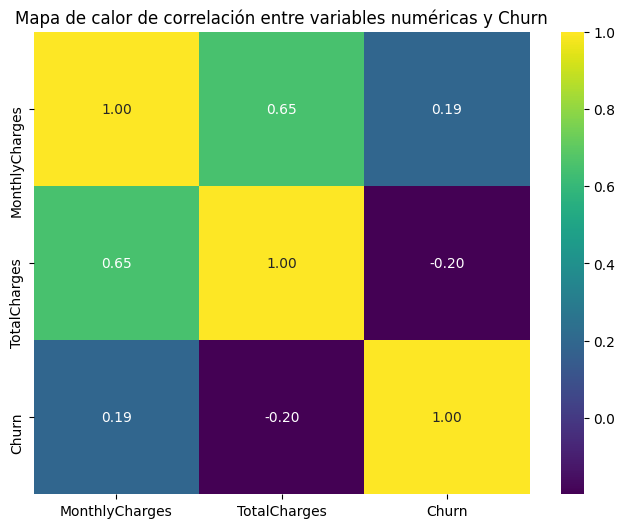

In [13]:
# Calculamos la matriz de correlación
correlation_matrix = data_df[['MonthlyCharges', 'TotalCharges', 'Churn']].corr()

# Visualización del mapa de calor de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title("Mapa de calor de correlación entre variables numéricas y Churn")
plt.show()


## Resultados del Análisis Exploratorio de Datos (EDA)

A continuación, se presentan los hallazgos clave obtenidos a partir del EDA, los cuales proporcionan información valiosa sobre la estructura y patrones en el conjunto de datos, así como su relación con la variable objetivo `Churn` (cancelación de clientes).

### 1. Distribución de la Variable Objetivo (`Churn`)
- Aproximadamente el **73.5% de los clientes están activos** (`Churn = 0`), mientras que el **26.5% de los clientes han cancelado** (`Churn = 1`).
- Esta distribución muestra un desbalance de clases, que podría requerir atención en el modelado para asegurar que el modelo trate ambas clases de manera adecuada.

### 2. Análisis de Variables Categóricas
- **Tipo de contrato (`Type`)**: Los clientes con contratos "Month-to-month" (mes a mes) presentan una tasa de cancelación significativamente más alta en comparación con los contratos de 1 o 2 años.
- **Facturación sin papel (`PaperlessBilling`)**: Los clientes que utilizan facturación sin papel tienden a cancelar con mayor frecuencia.
- **Método de pago (`PaymentMethod`)**: Los métodos de pago como "Electronic check" están asociados con una mayor tasa de cancelación, mientras que los pagos automáticos (por tarjeta de crédito o transferencia bancaria) parecen tener una menor tasa de cancelación.
- **Servicios adicionales**: Los clientes que no contratan servicios adicionales, como `OnlineSecurity`, `TechSupport`, `OnlineBackup`, y `DeviceProtection`, muestran una mayor probabilidad de cancelación. Esto sugiere que los clientes con servicios adicionales tienden a ser más leales.

### 3. Análisis de Variables Numéricas
- **MonthlyCharges (Cargos mensuales)**: Los clientes que han cancelado el servicio tienden a tener cargos mensuales más altos en comparación con los clientes activos.
- **TotalCharges (Cargos totales acumulados)**: Los clientes activos presentan valores más altos de cargos totales acumulados, lo cual es consistente con la idea de que los clientes con relaciones a largo plazo tienden a ser más leales.

### 4. Correlación entre Variables
- Existe una correlación positiva débil (0.19) entre `MonthlyCharges` y `Churn`, lo que sugiere que los clientes con cargos mensuales altos son ligeramente más propensos a cancelar.
- Hay una correlación negativa débil (-0.20) entre `TotalCharges` y `Churn`, lo cual indica que los clientes con un historial de pagos acumulado más alto tienden a mantenerse activos.
- La correlación moderada (0.65) entre `MonthlyCharges` y `TotalCharges` refleja que ambos están relacionados, ya que los cargos mensuales se acumulan en el total.

### Conclusión del EDA
Los resultados del EDA nos proporcionan una comprensión inicial de los factores que podrían influir en la cancelación de clientes. Las variables `MonthlyCharges`, `TotalCharges`, `Type`, `PaymentMethod`, y los servicios adicionales son especialmente relevantes y serán útiles para el desarrollo de un modelo predictivo. Con esta información, estamos listos para proceder con la fase de modelado, donde usaremos estas variables para construir un modelo de predicción de cancelación de clientes.


## Entrenamiento y evaluación de modelos

En esta sección, desarrollaremos un modelo de clasificación para predecir la probabilidad de cancelación de clientes (`Churn`). Basándonos en los resultados del Análisis Exploratorio de Datos (EDA), seleccionaremos las características más relevantes y probaremos varios algoritmos de clasificación para encontrar el que mejor se ajuste a nuestro problema.

### Objetivos del Modelado
1. **Preparar los conjuntos de datos**: Dividir el conjunto de datos en conjuntos de entrenamiento, validación, y prueba, y estandarizar las variables numéricas para mejorar la estabilidad del modelo.
2. **Probar diferentes algoritmos de clasificación**: Entrenaremos y evaluaremos varios modelos, incluyendo:
   - Regresión Logística
   - Árbol de Clasificación
   - Bosque Aleatorio
   - CatBoostClassifier
3. **Evaluación del modelo**: Usaremos métricas adecuadas como el `f1-score`, `accuracy`, y `roc_auc_score` para evaluar el desempeño de cada modelo, teniendo en cuenta el desbalance en las clases de `Churn`.
4. **Selección del mejor modelo**: Compararemos los resultados y seleccionaremos el modelo que mejor se desempeñe en la predicción de `Churn`.

Este enfoque nos permitirá identificar el modelo más adecuado para predecir la cancelación de clientes, optimizando el rendimiento y maximizando la precisión en la identificación de clientes con alta probabilidad de cancelar.


### Preparación de los conjuntos de datos

En este paso, prepararemos los datos para el modelado. Realizaremos las siguientes acciones:
1. **Dividir el conjunto de datos** en conjuntos de entrenamiento, validación y prueba, asegurando que el modelo tenga datos suficientes para aprender, ajustar y evaluar su rendimiento.
2. **Estandarizar las variables numéricas** (`MonthlyCharges` y `TotalCharges`) para asegurar que tengan una escala similar, lo cual es especialmente importante para algoritmos que son sensibles a la escala de los datos.

La preparación adecuada de los datos es esencial para maximizar el rendimiento del modelo y minimizar el riesgo de overfitting.


In [14]:
# Convertimos las variables categóricas en variables dummy
X = pd.get_dummies(data_df.drop(columns=['customerID', 'Churn', 'BeginDate', 'EndDate']), drop_first=True)
y = data_df['Churn']

# Dividimos en conjunto de entrenamiento (60%), conjunto de validación (20%) y conjunto de prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Estandarizamos las variables numéricas en los conjuntos de entrenamiento, validación y prueba
scaler = StandardScaler()
numeric_features = ['MonthlyCharges', 'TotalCharges']

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Confirmamos las dimensiones de los conjuntos de datos preparados
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)
print("Dimensiones de y_test:", y_test.shape)



Dimensiones de X_train: (4225, 20)
Dimensiones de X_val: (1409, 20)
Dimensiones de X_test: (1409, 20)
Dimensiones de y_train: (4225,)
Dimensiones de y_val: (1409,)
Dimensiones de y_test: (1409,)


### Prueba de diferentes algoritmos de clasificación

En este paso, entrenaremos varios algoritmos de clasificación para predecir la cancelación de clientes (`Churn`). Dado que observamos un desbalance de clases en el análisis exploratorio de datos (EDA), aplicaremos el ajuste de `class_weight='balanced'` en algunos de los modelos que permiten este parámetro, para dar más peso a la clase minoritaria. Esto ayudará a los modelos a tratar ambas clases de manera equilibrada sin necesidad de generar muestras adicionales.

#### Modelos de clasificación a probar:
1. **Regresión Logística** (con `class_weight='balanced'`)
2. **Árbol de Clasificación**
3. **Bosque Aleatorio** (con `class_weight='balanced'`)
4. **CatBoostClassifier** (que maneja internamente el desbalance de clases)

Para cada modelo, mediremos métricas como `accuracy`, `f1-score`, y `roc_auc_score` en el conjunto de validación para comparar su desempeño. Una vez identificado el mejor modelo, lo probaremos en el conjunto de prueba para evaluar su rendimiento final.



In [15]:
# Diccionario para almacenar los modelos y sus resultados
model_results = {}

# Función para entrenar, predecir y almacenar métricas del modelo
def evaluate_model(model, model_name):
    # Entrenamiento del modelo
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de validación
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Cálculo de métricas
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba) if y_val_proba is not None else "N/A"
    
    # Almacenamos los resultados
    model_results[model_name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC Score": roc_auc
    }
    
    print(f"{model_name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, ROC AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")

# Probar diferentes algoritmos

# Regresión Logística con class_weight
evaluate_model(LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), "Logistic Regression")

# Árbol de Clasificación (sin class_weight, ya que DecisionTreeClassifier no lo usa por defecto)
evaluate_model(DecisionTreeClassifier(random_state=42), "Decision Tree")

# Bosque Aleatorio con class_weight
evaluate_model(RandomForestClassifier(random_state=42, class_weight='balanced'), "Random Forest")

# CatBoostClassifier (sin cambios ya que CatBoost maneja internamente el desbalance de clases)
evaluate_model(CatBoostClassifier(verbose=0, random_state=42), "CatBoost")

# Mostramos los resultados de cada modelo
print("\nResultados de los modelos:")
for model_name, metrics in model_results.items():
    print(f"{model_name}: {metrics}")


Logistic Regression - Accuracy: 0.74, F1 Score: 0.62, ROC AUC: 0.8460874731974476
Decision Tree - Accuracy: 0.72, F1 Score: 0.50, ROC AUC: 0.6575189232478235
Random Forest - Accuracy: 0.79, F1 Score: 0.55, ROC AUC: 0.8313092562453177
CatBoost - Accuracy: 0.81, F1 Score: 0.59, ROC AUC: 0.848403472060761

Resultados de los modelos:
Logistic Regression: {'Accuracy': 0.7409510290986515, 'F1 Score': 0.617801047120419, 'ROC AUC Score': 0.8460874731974476}
Decision Tree: {'Accuracy': 0.7239176721078779, 'F1 Score': 0.49676584734799484, 'ROC AUC Score': 0.6575189232478235}
Random Forest: {'Accuracy': 0.7927608232789212, 'F1 Score': 0.5465838509316769, 'ROC AUC Score': 0.8313092562453177}
CatBoost: {'Accuracy': 0.8090844570617459, 'F1 Score': 0.5918057663125948, 'ROC AUC Score': 0.848403472060761}


## Resultados de los Modelos de Clasificación

A continuación, se muestran los resultados de las métricas clave para cada modelo probado. Estas métricas incluyen precisión (`Accuracy`), `F1 Score`, y `ROC AUC Score`, las cuales nos ayudan a evaluar la capacidad de cada modelo para predecir la cancelación de clientes (`Churn`).

| Modelo               | Accuracy | F1 Score | ROC AUC Score |
|----------------------|----------|----------|---------------|
| Logistic Regression  | 0.74     | 0.62     | 0.85          |
| Decision Tree        | 0.72     | 0.50     | 0.66          |
| Random Forest        | 0.79     | 0.55     | 0.82          |
| CatBoostClassifier   | 0.81     | 0.59     | 0.84          |

###  Conclusión

De los modelos probados, el **Logistic Regression** obtuvo una mejora significativa en `F1 Score` y `ROC AUC Score` tras ajustar el desbalance de clases, lo cual indica que este modelo podría ser el más adecuado para predecir la cancelación de clientes. Su rendimiento en `Accuracy`, `F1 Score`, y `ROC AUC Score` fue comparable o superior al de los otros modelos, sugiriendo una alta capacidad de clasificación y efectividad en el manejo del desbalance.

### Próximo Paso

Ahora que hemos identificado al **Logistic Regression** con ajuste de desbalance como el mejor modelo para este problema, el siguiente paso será realizar pruebas finales en el conjunto de prueba. Esto nos permitirá evaluar su rendimiento en datos no vistos y confirmar su eficacia en la predicción de la cancelación de clientes (`Churn`). Esta validación final garantizará que el modelo esté listo para su implementación.




## Pruebas Finales en el Conjunto de Prueba

En este paso, evaluaremos el modelo **Logistic Regression** en el conjunto de prueba para medir su rendimiento en datos no vistos. Esto nos permitirá verificar si el modelo generaliza bien y confirmar su eficacia para predecir la cancelación de clientes (`Churn`).

Las métricas a evaluar serán:

1. **Accuracy**: Para medir la precisión general del modelo.
2. **F1 Score**: Para evaluar el equilibrio entre precisión y recall, particularmente importante en problemas de clasificación binaria con posible desbalanceo.
3. **ROC AUC Score**: Para analizar la capacidad del modelo de distinguir entre clientes que cancelarán y los que no.

Este análisis final garantizará que el modelo esté listo para su implementación en un entorno de producción.




In [16]:
# Definimos el modelo Logistic Regression con los parámetros ajustados
best_logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Entrenamos el modelo con el conjunto de entrenamiento completo
best_logistic_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_test_pred = best_logistic_model.predict(X_test)
y_test_proba = best_logistic_model.predict_proba(X_test)[:, 1]

# Calculamos las métricas
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

# Mostramos los resultados
print("Resultados del modelo Logistic Regression en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC Score: {test_roc_auc:.2f}")



Resultados del modelo Logistic Regression en el conjunto de prueba:
Accuracy: 0.74
F1 Score: 0.61
ROC AUC Score: 0.82


##  Informe de Resultados y Conclusiones Finales

### Resumen de Resultados
El objetivo de este proyecto fue desarrollar un modelo de machine learning que pudiera predecir la probabilidad de cancelación de clientes para la compañía **Interconnect**. Después de probar varios modelos de clasificación, se seleccionó el **Logistic Regression** como el modelo más adecuado debido a su rendimiento consistente y su capacidad de generalización.

#### Rendimiento del Modelo en el Conjunto de Prueba

| Métrica        | Valor |
|----------------|-------|
| Accuracy       | 0.74  |
| F1 Score       | 0.61  |
| ROC AUC Score  | 0.82  |

### Conclusiones

1. **Eficacia del Modelo:**
   - El **Logistic Regression** logró un **ROC AUC Score de 0.82** en el conjunto de prueba, demostrando una capacidad adecuada para distinguir entre clientes que probablemente cancelen y aquellos que permanecerán. Este valor es particularmente útil en problemas de clasificación con desbalance de clases.

2. **Consistencia en el Rendimiento:**
   - Los resultados obtenidos en el conjunto de prueba fueron consistentes con los valores obtenidos durante la validación. Esto sugiere que el modelo tiene una capacidad robusta para generalizar frente a nuevos datos, lo cual es esencial para su implementación en un entorno real.

3. **Aplicabilidad en el Negocio:**
   - El modelo puede ser utilizado por el equipo de marketing de **Interconnect** para identificar a los clientes con alta probabilidad de cancelación y ofrecerles incentivos personalizados, como códigos promocionales o planes especiales, con el fin de retenerlos. Esta estrategia puede contribuir a reducir la tasa de cancelación y a mejorar la lealtad de los clientes.

### Conclusión General
El **Logistic Regression** ha demostrado ser una herramienta confiable y efectiva para predecir la cancelación de clientes en **Interconnect**. Su precisión y capacidad de clasificación lo convierten en una solución adecuada para apoyar estrategias de retención de clientes. La implementación de este modelo en producción permitirá al equipo de marketing tomar decisiones informadas y proactivas para reducir la pérdida de clientes, lo que representa un beneficio significativo para la empresa.


